# DOE 本番解析用 (base) v2

### ライブラリの一括インポート

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### ファイル名から日付を返す関数

In [4]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## CSV ファイル一覧の取得

In [5]:
name_doe = "doe-6"  # 実験計画名（フォルダ名）
name_code = "7011"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{8})\..+")
if m := pattern_date.match(file_last):
    date_str = m.group(1)  # 保存ファイル目に付与する日付
else:
    date_str = "00000000"
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv', 'ticks_20250925.csv', 'ticks_20250926.csv', 'ticks_20250929.csv', 'ticks_20250930.csv', 'ticks_20251001.csv', 'ticks_20251002.csv', 'ticks_20251003.csv', 'ticks_20251006.csv', 'ticks_20251007.csv', 'ticks_20251008.csv', 'ticks_20251009.csv', 'ticks_20251010.csv', 'ticks_20251014.csv', 'ticks_20251015.csv', 'ticks_20251016.csv', 'ticks_20251017.csv', 'ticks_20251020.csv', 'ticks_20251021.csv', 'ticks_20251022.csv', 'ticks_2025

## CSV ファイルの読み込み、連結

In [6]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "trade", "total"]
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

# HTML 形式で出力
styled = df_latest.style.format(
    {"取引回数": "{:d}", "損益": "{:.1f}"}
).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)
html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_latest_single.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)
df.to_pickle(f"{name_doe}_{name_code}.pkl")

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件")
print(df_latest_max)


日毎のシミュレーション結果例（連結前）
                    file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
0    ticks_20250819.xlsx  7011     16           30          300   60.0
1    ticks_20250819.xlsx  7011     12           45          300   40.0
2    ticks_20250819.xlsx  7011     14           60          300   72.0
3    ticks_20250819.xlsx  7011     10           75          300   98.0
4    ticks_20250819.xlsx  7011      6           90          300   37.0
..                   ...   ...    ...          ...          ...    ...
116  ticks_20250819.xlsx  7011      6          120          900   35.0
117  ticks_20250819.xlsx  7011      4          135          900   26.0
118  ticks_20250819.xlsx  7011      4          150          900   27.0
119  ticks_20250819.xlsx  7011      4          165          900   27.0
120  ticks_20250819.xlsx  7011      2          180          900  -19.0

[121 rows x 6 columns]

日毎のシミュレーション結果を連結したデータフレーム
                      file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
0  

### 本日の条件

In [7]:
x_por = 60
y_por =  780
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
print(df_latest[(df_latest[col_x] == x_por) & (df_latest[col_y] == y_por)])

    PERIOD_MA_1  PERIOD_MA_2  取引回数    損益 備考
90           60          780     4  12.0   


## 最終日のデータだけで作成した等高線図

In [8]:
plt.rcParams["font.size"] = 12
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

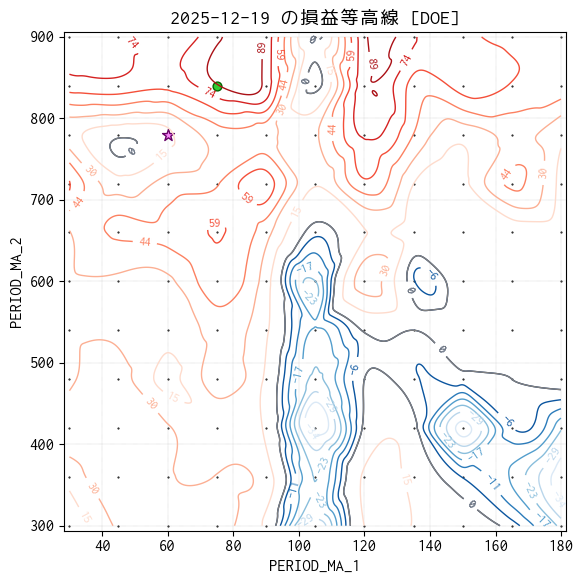

In [9]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(
    Xi, Yi, Zi,
    levels=levels_pos,
    cmap="Reds",
    linewidths=1
)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(
    Xi, Yi, Zi,
    levels=levels_neg,
    cmap="Blues",
    linewidths=1
)

# z=0 の等高線（黒）
cont0 = ax.contour(
    Xi, Yi, Zi,
    levels=[0],
    colors="gray",
    linewidths=1
)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.scatter(
    df_latest_max[col_x],
    df_latest_max[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    x_por,
    y_por,
    marker="*",
    facecolor="#f8f",
    edgecolor="#606",
    s=80,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"{dt_last.date()} の損益等高線 [DOE]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_contour_single.png"
)

#plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
#plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

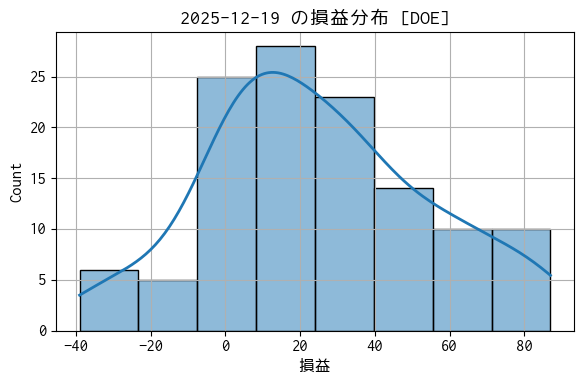

In [10]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_latest,
    x="損益",
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(f"{dt_last.date()} の損益分布 [DOE]")

plt.tight_layout()
output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_hist_single.png"
)
plt.savefig(output)
plt.show()

## 最大・最小収益（ヒストリカル）

In [11]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高収益")
print(df[df["total"] == total_max])
print("\n最低収益")
print(df[df["total"] == total_min])

最高収益
                     file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
6371  ticks_20251105.xlsx  7011     18           60          720  321.0

最低収益
                     file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
5866  ticks_20251029.xlsx  7011     28           75          600 -189.0


## サマリ統計の算出

In [12]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary = df_summary.sort_values(["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True)
print("サマリ統計")
print(df_summary)

# HTML 形式で出力
styled = df_summary.style.format(
    {"trade": "{:.1f}", "total": "{:.2f}"}
).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)
html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_summary.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

サマリ統計
     PERIOD_MA_1  PERIOD_MA_2      trade      total
0             30          300  30.023810   3.809524
1             45          300  22.285714   1.357143
2             60          300  20.928571   2.761905
3             75          300  18.738095   5.023810
4             90          300  17.095238   1.773810
..           ...          ...        ...        ...
116          120          900   8.190476  13.285714
117          135          900   8.000000  12.309524
118          150          900   7.404762  10.702381
119          165          900   6.904762   6.976190
120          180          900   6.666667   5.011905

[121 rows x 4 columns]


## 日付 × 条件 で収益を集計

In [13]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で収益")
print(df_raw)


df_raw: 日付 x 条件で収益
             0     1     2     3     4     5     6     7     8     9    ...  \
2025-08-19  60.0  40.0  72.0  98.0  37.0  39.0  29.0  45.0  43.0  49.0  ...   
2025-08-20  17.0 -13.0  -6.0  41.0  53.0   2.0 -13.0  27.0  40.0  -3.0  ...   
2025-08-21 -26.0 -17.0  12.0  16.0  19.0  24.0  35.0  32.0   4.0  -7.0  ...   
2025-08-22 -11.0 -27.0 -24.0 -30.0 -13.0 -11.0   6.0 -12.0 -11.0   0.0  ...   
2025-08-25  10.0  15.0  18.0   7.0  -7.0 -13.0  -6.0  -8.0 -14.0 -14.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2025-12-15  27.0  20.0 -14.0  -3.0 -16.0 -16.0  -2.0  -4.0 -27.0   6.0  ...   
2025-12-16  18.0  -6.0  -2.0  17.0  15.0  59.0  57.0  62.0  22.0  20.0  ...   
2025-12-17 -15.0  10.0  13.0   1.0 -25.0  19.0  -2.0   3.0  55.0  34.0  ...   
2025-12-18 -29.0 -22.0   1.0   4.0 -22.0 -27.0 -21.0 -44.0 -36.0   7.0  ...   
2025-12-19   0.0  32.0  38.0  33.0  11.0 -34.0  15.0  14.0   5.0  -3.0  ...   

             111   112   113   

## 平均収益の算出

In [14]:
df_mean = df_raw.copy()
# データスコープを示す文字列
dt_start = df_mean.index[0]
dt_end = df_mean.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均収益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均収益（逆ソート後）")
print(ser_ranking)

データスコープを示す文字列
三菱重工業 (7011) from 2025-08-19 to 2025-12-19, n = 84 days

df_mean: 新しい日付から古い日付と逆順に平均収益を算出
                  0          1          2          3          4          5    \
2025-08-19  60.000000  40.000000  72.000000  98.000000  37.000000  39.000000   
2025-08-20  38.500000  13.500000  33.000000  69.500000  45.000000  20.500000   
2025-08-21  17.000000   3.333333  26.000000  51.666667  36.333333  21.666667   
2025-08-22  10.000000  -4.250000  13.500000  31.250000  24.000000  13.500000   
2025-08-25  10.000000  -0.400000  14.400000  26.400000  17.800000   8.200000   
...               ...        ...        ...        ...        ...        ...   
2025-12-15   4.325000   1.250000   2.275000   4.587500   2.125000   1.300000   
2025-12-16   4.493827   1.160494   2.222222   4.740741   2.283951   2.012346   
2025-12-17   4.256098   1.268293   2.353659   4.695122   1.951220   2.219512   
2025-12-18   3.855422   0.987952   2.337349   4.686747   1.662651   1.867470   
2025-12-19   3.80

### 検算

In [15]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## 今日（最終データ）のベスト収益

In [16]:
dt_last = df_raw.index[-1]
df_raw_last = df_raw.loc[date_str]
total_last_max = df_raw_last.max()
colname_last_best = df_raw_last[df_raw_last == total_last_max].index[0]

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "total"]
df_last_max = pd.DataFrame(df_summary.loc[colname_last_best][list_col]).T.copy()
df_last_max.loc[colname_last_best, "total"] = total_last_max
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "損益"]
df_last_max.columns = list_col_new
print(f"最終日 ({dt_last.date()}) の最高収益条件")
print(df_last_max)

最終日 (2025-12-19) の最高収益条件
     PERIOD_MA_1  PERIOD_MA_2    損益
102         75.0        840.0  87.0


## ランキング

In [17]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_best.columns=list_col
dt_last = df_raw.index[-1]
ser_best_last = df_raw.loc[dt_last][best_conditions]
df_best[dt_last.date()] = ser_best_last

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_best.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_negative.columns=list_col
dt_last = df_raw.index[-1]
ser_negative_last = df_raw.loc[dt_last][negative_conditions]
df_negative[dt_last.date()] = ser_negative_last

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2       取引回数       平均損益  2025-12-19
47            75          540  13.761905  15.440476        35.0
90            60          780  13.857143  14.428571        12.0
57            60          600  15.452381  13.964286        26.0
49           105          540  11.619048  13.666667       -18.0
116          120          900   8.190476  13.285714        85.0
---
[Bad Conditions]
Empty DataFrame
Columns: [PERIOD_MA_1, PERIOD_MA_2, 取引回数, 平均損益, 2025-12-19]
Index: []


## 実験条件毎の収益トレンド

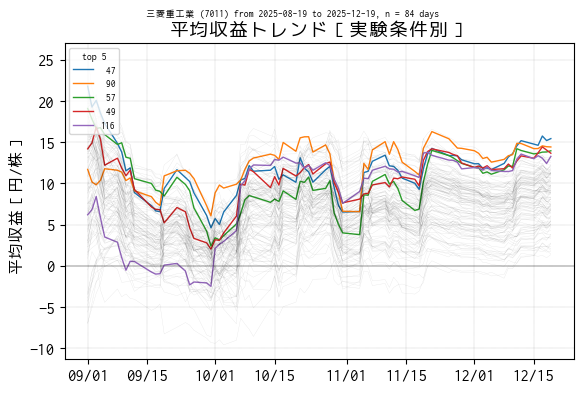

In [18]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均収益［円/株］")
ax.set_title("平均収益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_mean_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ収益条件 (mean) の日別収益トレンド

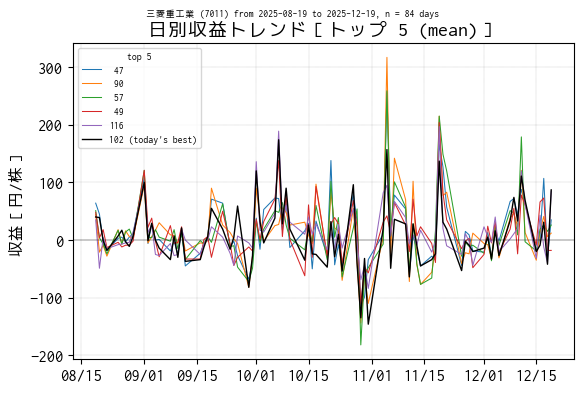

In [19]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("収益［円/株］")
ax.set_title("日別収益トレンド［トップ 5 (mean)］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_daily_profit_1.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

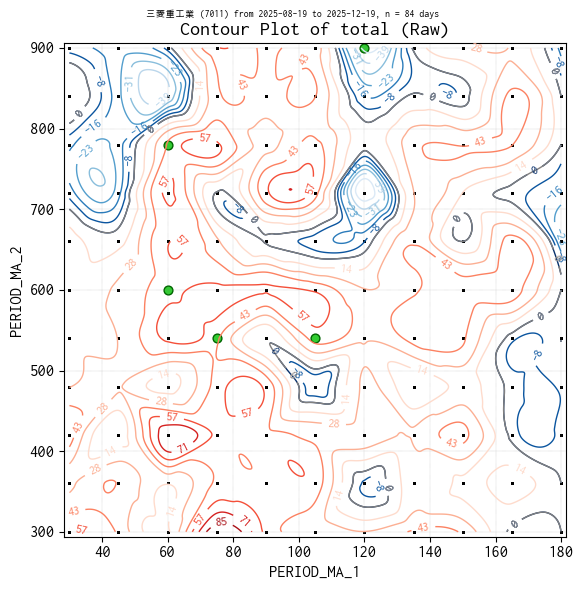

In [20]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# Contour Map
#cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm", linewidths=1)
#ax.clabel(cont, inline=True, fontsize=9)

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(
    Xi, Yi, Zi,
    levels=levels_pos,
    cmap="Reds",
    linewidths=1
)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(
    Xi, Yi, Zi,
    levels=levels_neg,
    cmap="Blues",
    linewidths=1
)

# z=0 の等高線（黒）
cont0 = ax.contour(
    Xi, Yi, Zi,
    levels=[0],
    colors="gray",
    linewidths=1
)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_best[col_x],
    df_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_raw_contour_{target}.png"
)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## メディアン収益の算出

In [21]:
df_median = df_raw.copy()
# データスコープを示す文字列
dt_start = df_median.index[0]
dt_end = df_median.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

データスコープを示す文字列
三菱重工業 (7011) from 2025-08-19 to 2025-12-19, n = 84 days


In [22]:
n = len(df_median.index)

In [23]:
df_median[:n].median()

0      0.0
1     -3.0
2     -2.0
3     -0.5
4      0.0
      ... 
116    5.5
117    7.0
118    1.5
119    0.0
120   -1.0
Length: 121, dtype: float64

In [24]:
# メディアン収益の算出
n = len(df_median.index)
while n > 0:
    # 最下行から順にメディアンを算出して、行の内容を置換。
    df_median.iloc[n - 1] = df_median[:n].median()
    n -= 1
print("\ndf_median: 新しい日付から古い日付と逆順にメディアン収益を算出")
print(df_median)

# 最終日の平均収益のランキング
ser_ranking = df_median.iloc[len(df_median) - 1].sort_values(ascending=False)
print("最新のメディアン収益（逆ソート後）")
print(ser_ranking)


df_median: 新しい日付から古い日付と逆順にメディアン収益を算出
             0     1     2     3     4     5     6     7     8     9    ...  \
2025-08-19  60.0  40.0  72.0  98.0  37.0  39.0  29.0  45.0  43.0  49.0  ...   
2025-08-20  38.5  13.5  33.0  69.5  45.0  20.5   8.0  36.0  41.5  23.0  ...   
2025-08-21  17.0 -13.0  12.0  41.0  37.0  24.0  29.0  32.0  40.0  -3.0  ...   
2025-08-22   3.0 -15.0   3.0  28.5  28.0  13.0  17.5  29.5  22.0  -1.5  ...   
2025-08-25  10.0 -13.0  12.0  16.0  19.0   2.0   6.0  27.0   4.0  -3.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2025-12-15   0.5  -3.0  -2.5  -2.0   0.0  -0.5  -2.0   1.0  -2.0  -2.0  ...   
2025-12-16   1.0  -4.0  -2.0  -1.0   0.0   0.0  -2.0   1.0  -2.0  -1.0  ...   
2025-12-17   0.5  -3.0  -2.0  -1.0   0.0   0.0  -2.0   1.0  -1.5  -0.5  ...   
2025-12-18   0.0  -4.0  -2.0  -1.0   0.0   0.0  -2.0   1.0  -2.0   0.0  ...   
2025-12-19   0.0  -3.0  -2.0  -0.5   0.0  -0.5  -2.0   1.0  -1.5  -0.5  ...   

             

## サマリ統計（メディアン）

In [25]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答のメディアンを集計（サマリデータ）
df_summary_2 = df.groupby(factor_cols)[response_cols].median().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary_2 = df_summary_2.sort_values(
    ["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True
)
print("サマリ統計（メディアン）")
print(df_summary_2)

サマリ統計（メディアン）
     PERIOD_MA_1  PERIOD_MA_2  trade  total
0             30          300   26.0    0.0
1             45          300   20.0   -3.0
2             60          300   20.0   -2.0
3             75          300   16.0   -0.5
4             90          300   16.0    0.0
..           ...          ...    ...    ...
116          120          900    8.0    5.5
117          135          900    7.0    7.0
118          150          900    6.0    1.5
119          165          900    6.0    0.0
120          180          900    6.0   -1.0

[121 rows x 4 columns]


### 検算

In [26]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary_2["total"] - df_median.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング (2)

In [27]:
# トップランキング
n_top = 10
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_best.columns=list_col
dt_last = df_raw.index[-1]
ser_best_last = df_raw.loc[dt_last][best_conditions]
df_best[dt_last.date()] = ser_best_last

print("---\n[Best Conditions]")
print(df_best)



# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_best_median.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)


# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary_2.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_negative.columns=list_col
dt_last = df_raw.index[-1]
ser_negative_last = df_raw.loc[dt_last][negative_conditions]
df_negative[dt_last.date()] = ser_negative_last

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2       取引回数     メジアン損益  2025-12-19
68            60          660  14.571429  11.178571        48.0
90            60          780  13.857143  14.428571        12.0
117          135          900   8.000000  12.309524        76.0
44            30          540  21.619048  11.166667        26.0
46            60          540  15.642857  13.214286        17.0
29           135          420  11.619048   9.142857         3.0
59            90          600  11.547619  10.297619        21.0
116          120          900   8.190476  13.285714        85.0
79            60          720  14.380952  13.119048        35.0
62           135          600   9.619048   8.880952        -5.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2  取引回数  メジアン損益  2025-12-19
70            90          660  10.0    -0.5        35.0
82           105          720  10.0    -0.5        16.0
93           105          780   9.0    -0.5        27.0
3             75          300

## 実験条件毎の収益トレンド（メディアン）

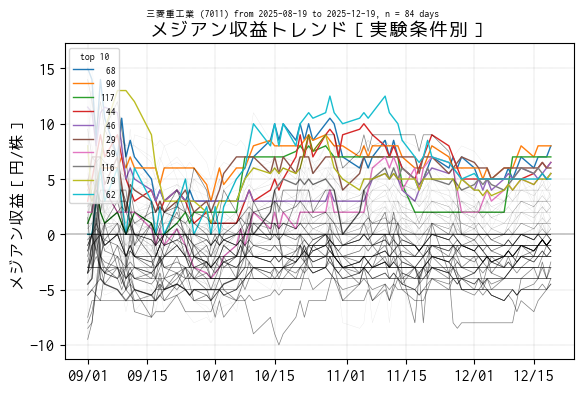

In [28]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_median[dt_from <= df_median.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップ 5 だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(
            df_trend[colname],
            linewidth=0.5,
            linestyle="solid",
            color="black",
            alpha=0.5,
        )
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("メジアン収益［円/株］")
ax.set_title("メジアン収益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_median_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ収益条件 (median) の日別収益トレンド

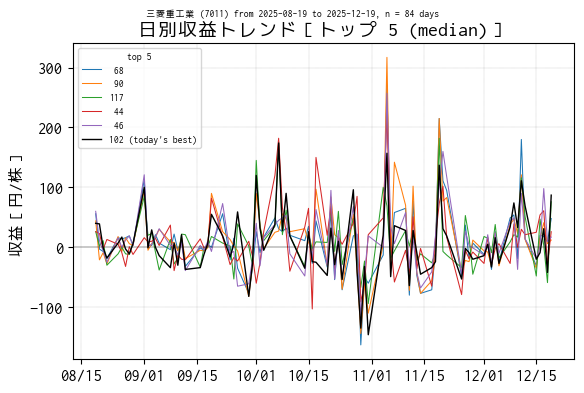

In [29]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("収益［円/株］")
ax.set_title("日別収益トレンド［トップ 5 (median)］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title("top 5", prop={"size": 7})
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_daily_profit_2.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()